## Kaggle - Dog Breed Identification
[Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification) 문제에서는 사진에 있는 강아지의 종을 확인해야 한다. 따라서 이미지에 특화된 전처리 기법과 모델이 사용 되어야 한다.

파이썬에선 `pillow`(말고도 `OpenCV`라는 다양한 기능을 가진 패키지도 존재)라는 이미지 전처리 패키지가 있다. 이를 모델 구성에 이용하자.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle

파일을 업로드하기 위해 `os.listdir`를 이용하여 파일 이름을 알아내야 한다.

In [ ]:
trlist = os.listdir("./data/dog_breed/train")
tstlist = os.listdir("./data/dog_breed/test")

trlist[:5]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
len(trlist), len(tstlist)

(10222, 10357)

이미지를 업로드하고 numpy 배열로 만든다

In [ ]:
px_tr, px_t = [], []

for fname in tqdm(trlist):
    img = Image.open("./data/dog_breed/train/" + fname)
    px_tr.append(np.array(img))
    img.close()
    
for fname in tqdm(tstlist):
    img = Image.open("./data/dog_breed/test/" + fname)
    px_t.append(np.array(img))
    img.close()
    
len(px_tr), len(px_t)

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [01:26<00:00, 120.36it/s]


(10222, 10357)

In [ ]:
px_tr[0]

array([[[108,  46,   0],
        [152,  92,  42],
        [180, 120,  70],
        ...,
        [176, 144,  69],
        [189, 157,  82],
        [214, 182, 107]],

       [[151,  93,  47],
        [179, 121,  75],
        [167, 111,  64],
        ...,
        [167, 136,  56],
        [172, 139,  60],
        [188, 157,  77]],

       [[151,  98,  56],
        [188, 137,  94],
        [162, 113,  70],
        ...,
        [200, 168,  81],
        [196, 162,  75],
        [200, 168,  81]],

       ...,

       [[189, 122,  69],
        [186, 119,  66],
        [183, 116,  63],
        ...,
        [213, 160, 106],
        [212, 159, 107],
        [209, 156, 102]],

       [[186, 119,  66],
        [184, 117,  64],
        [183, 116,  63],
        ...,
        [197, 145,  88],
        [199, 146,  92],
        [199, 147,  90]],

       [[182, 115,  62],
        [181, 114,  61],
        [183, 116,  63],
        ...,
        [184, 132,  74],
        [190, 138,  81],
        [192, 140,  82]]

In [ ]:
px_tr[0].shape

(375, 500, 3)

375x500 픽셀 이미지에 대한 데이터가 잘 업로드 되었음을 확인 할 수 있다. 이 때 한 픽셀에 대한 색깔을 나타내기 위해 세개의 숫자인 RGB값이 필요하므로 375x500x3 텐서가 생성되었다.

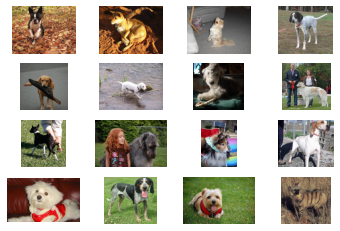

In [ ]:
fig, ax = plt.subplots(4, 4)

for i, ax in enumerate(ax.flat):
    ax.axis("off")
    ax.imshow(px_tr[i])

각 이미지마다 크기가 다르다. 모델의 입력 크기는 고정되어 있으므로 모두 똑같이 바꾼다. 많은 유명한 모델들의 입력 크기난 224x224 이므로 이에 맞춰서 사이즈를 바꾸자.

해상도를 낮추는 알고리즘도 사용하는 필터에 따라 여러가지가 있다.
- NEAREST

- BOX

- BILINEAR

- HAMMING

- BICUBIC

- LANCZOS

아래 필터를 사용할 수록 품질은 높지만 속도가 느리다. 최상의 품질을 위해 LANCZOS 필터를 사용 해 보자.

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:52<00:00, 198.92it/s]


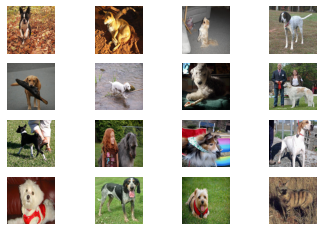

In [ ]:
resize_tr, resize_t = [], []

for px in tqdm(px_tr):
    img = Image.fromarray(px)
    img = img.resize((224, 224), Image.LANCZOS)
    px_resize = np.array(img)
    
    resize_tr.append(px_resize)
    
for px in tqdm(px_t):
    img = Image.fromarray(px)
    img = img.resize((224, 224), Image.LANCZOS)
    px_resize = np.array(img)
    
    resize_t.append(px_resize)
    
fig, ax = plt.subplots(4, 4)

for i, ax in enumerate(ax.flat):
    ax.axis("off")
    ax.imshow(resize_tr[i])

In [ ]:
all(x.shape == (224, 224, 3) for x in resize_tr), all(x.shape == (224, 224, 3) for x in resize_t)

(True, True)

데이터 전부 합치기

In [ ]:
resize_tr = np.concatenate(resize_tr).reshape(-1,224,224,3)
resize_t = np.concatenate(resize_t).reshape(-1,224,224,3)

resize_tr.shape

(10222, 224, 224, 3)

In [ ]:
resize_t.shape

(10357, 224, 224, 3)

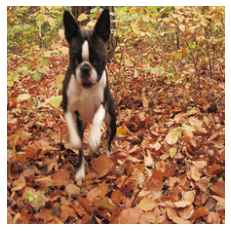

In [ ]:
plt.axis("off")
plt.imshow(resize_tr[0])

10222개의 학습 데이터셋과 10357개의 테스트 데이터 셋 모두 전처리 후 numpy array 로 변환 하였다.

## pickle
전처리 및 분석 과정에서 필요한 데이터를 그대로 저장하여 나중에 쓰고 싶으면 `pickle` 패키지를 이용하면 된다. 이를 통해 중단했던 작업을 이전 코드를 실행 하지 않고 저장한 데이터를 불러 와서 시작할 수 있다.

이번 문제의 경우 대용량의 데이터를 다루어 코드의 실행시간이 오래 걸리므로 pickle을 적극 이용할 필요가 있다.

해상도를 조정한 이미지들을 pickle로 저장해보자.

In [ ]:
with open("data/dog_breed/resize_tr.pickle", "wb") as f:
    pickle.dump(resize_tr, f)
with open("data/dog_breed/resize_t.pickle", "wb") as f:
    pickle.dump(resize_t, f)

중단 했을 경우 pickle로 저장한 데이터를 다시 가져온다. 이 때, 패키지 import 해주는 처음 코드는 실행 해야한다.

In [ ]:
with open("data/dog_breed/resize_tr.pickle", "rb") as f:
    resize_tr = pickle.load(f)

In [ ]:
labels = pd.read_csv("./data/dog_breed/labels.csv")

labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
id_tr = list(map(lambda x:x.split('.')[0], trlist))

id_tr[:5]

['000bec180eb18c7604dcecc8fe0dba07',
 '001513dfcb2ffafc82cccf4d8bbaba97',
 '001cdf01b096e06d78e9e5112d419397',
 '00214f311d5d2247d5dfe4fe24b2303d',
 '0021f9ceb3235effd7fcde7f7538ed62']

In [ ]:
breed_tr = list(map(lambda x:labels[labels["id"] == x]["breed"], id_tr))
breed_tr = np.array(breed_tr).squeeze()
breed_tr, uniques = pd.factorize(breed_tr)

breed_tr[:5]

array([0, 1, 2, 3, 4], dtype=int64)

In [ ]:
len(uniques)

120

위 과정을 통해 레이블도 수치화하였다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_tst, y_tr, y_tst = train_test_split(resize_tr, breed_tr, test_size=0.3)

X_tr.shape

(7155, 224, 224, 3)

메모리를 많이 차지하는 필요없는 데이터를 삭제한다. `uniques`는 나중에 필요하기 때문에 삭제하지 않는다.

In [ ]:
del resize_tr, breed_tr, id_tr, labels

CNN에 맞게 차원을 바꾼다.

In [ ]:
X_tr = X_tr.transpose((0, 3, 1, 2))
X_tst = X_tst.transpose((0, 3, 1, 2))

X_tr.shape

(7155, 3, 224, 224)

In [ ]:
X_tr, X_tst, y_tr, y_tst = map(lambda x: torch.tensor(x), [X_tr, X_tst, y_tr, y_tst])

X_tr.dtype, y_tr.dtype

(torch.uint8, torch.int64)

일반적으로 이미지 데이터를 학습시킬 때는 (0, 1)의 값을 만들어 주기 위해 모든 픽셀 값을 255로 나누어 준다.

255로 나누게 되면 이전 uint8 에 비해 float32 가 되어 4배의 메모리를 차지하게 된다.

In [ ]:
X_tr = X_tr / 255
X_tst = X_tst / 255

X_tr.dtype

torch.float32

간단한 CNN 모델을 작성해보자.

In [ ]:
class DogBreedIdentifier(nn.Module):
    def __init__(self, lr=1e-4):
        super(DogBreedIdentifier, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 64, kernel_size=14, stride=5), # (3, 224, 224)->(64, 43, 43)
            nn.MaxPool2d(3, padding=1), # (64, 43, 43)->(64, 15, 15)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=6, stride=1), # (64, 15, 15)->(128, 10, 10)
        )

        self.linear = nn.Sequential(
            nn.BatchNorm1d(128*10*10),
            nn.Linear(128*10*10, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.Softmax(dim=1)
        )
        self.optim = optim.Adam(self.parameters(), lr=lr)
        self.sched = optim.lr_scheduler.LambdaLR(optimizer=self.optim,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, X):
        out = self.conv(X).reshape(-1, 128*10*10)
        out = self.linear(out)
        return out
    
    def backward(self, X, y):
        self.optim.zero_grad()
        
        out = self.forward(X)
        loss = self.loss(out, y)
        loss.backward()
        self.optim.step()
        self.sched.step()
        
        return loss, out

In [ ]:
bs = 16
model = DogBreedIdentifier()
ds = TensorDataset(X_tr, y_tr)
loader = DataLoader(ds, bs, shuffle=True)
epoch_num = 5

loss_h = []
loss_sum = 0
cnt = 0

In [ ]:
for epoch in range(epoch_num):
    for X_b, y_b in tqdm(loader):
        loss, p = model.backward(X_b, y_b)
        loss_sum += loss.item()
        cnt += 1
        
        if cnt == 20:
            loss_h.append(loss_sum / cnt)
            cnt = 0
            loss_sum = 0

100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [02:21<00:00,  3.17it/s]


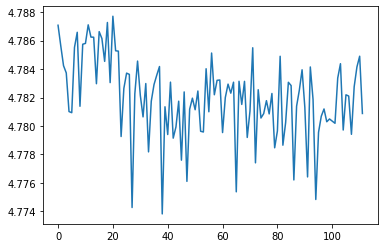

In [ ]:
plt.plot(loss_h)
plt.show()

In [ ]:
y_prob = model(X_tst)
y_hat = y_prob.argmax(1)
acc = (y_tst==y_hat).sum() / y_hat.shape[0]

acc.item()

0.023149657994508743

직접 만든 모델은 학습이 잘 되지 않는것으로 보인다. 실제로 어려운 데이터에 대해 잘 작동하는 모델을 직접 만들기란 쉽지 않다.
[torchvision.models](https://pytorch.org/vision/stable/models.html)에 이미지 데이터에 잘 작동하는 유명한 모델들을 제공한다. 게다가 이러한 모델들은 이미 학습까지 되어있어 학습 시간도 절약 할 수 있다.

이미 모든 이미지 데이터를 224x224로 바꿨기 때문에 더이상 전처리 할 필요도 없다.

In [ ]:
from torchvision import models

`ResNet18`을 이용해보자.
- 더 정확도가 높은 모델도 있지만 다른 모델은 더 복잡한 구조로 되어 있어 많은 연산을 요구한다. 환경의 컴퓨팅 파워를 감안하여 모델을 선택해야 한다.

In [ ]:
resnet = models.resnet18(pretrained=True)

In [ ]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
resnet(X_tr[:10]).shape

torch.Size([10, 1000])

In [ ]:
class PretrainedModel(nn.Module):
    def __init__(self, model):
        super(PretrainedModel, self).__init__()
        for param in model.parameters():
            param.requires_grad = False
        self.base = model
        
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 120)
        )
        
    def forward(self, X):
        out = self.base(X)
        out = self.seq(out)
        return out
    
    def acc_score(self, y_hat, y_t):
        acc = (y_t==y_hat).sum() / y_hat.shape[0]
        
        return acc.item()

각 분류에 해당하는 데이터의 개수를 감안하여 손실을 계산하기 위해 가중치 값을 구한다.

In [ ]:
counter = torch.zeros(120)
for i in range(120):
    counter[i] = (y_tr == i).sum()
counter

tensor([61., 55., 56., 57., 51., 65., 55., 72., 85., 53., 49., 74., 54., 63.,
        54., 52., 74., 54., 50., 53., 51., 57., 58., 78., 57., 59., 68., 54.,
        58., 48., 61., 57., 61., 58., 72., 60., 79., 58., 43., 46., 57., 55.,
        78., 57., 55., 56., 58., 54., 75., 52., 56., 68., 68., 50., 82., 51.,
        58., 57., 52., 69., 62., 50., 44., 73., 73., 56., 55., 86., 47., 58.,
        51., 60., 56., 56., 78., 52., 58., 80., 49., 69., 48., 56., 69., 49.,
        54., 56., 57., 60., 59., 64., 64., 45., 56., 61., 74., 68., 53., 52.,
        59., 71., 68., 59., 57., 79., 54., 84., 51., 59., 58., 55., 72., 67.,
        51., 55., 46., 59., 49., 55., 55., 56.])

In [ ]:
weight = 1 / counter
weight = weight / weight.sum()

weight

tensor([0.0080, 0.0088, 0.0087, 0.0085, 0.0095, 0.0075, 0.0088, 0.0067, 0.0057,
        0.0092, 0.0099, 0.0066, 0.0090, 0.0077, 0.0090, 0.0093, 0.0066, 0.0090,
        0.0097, 0.0092, 0.0095, 0.0085, 0.0084, 0.0062, 0.0085, 0.0082, 0.0071,
        0.0090, 0.0084, 0.0101, 0.0080, 0.0085, 0.0080, 0.0084, 0.0067, 0.0081,
        0.0061, 0.0084, 0.0113, 0.0106, 0.0085, 0.0088, 0.0062, 0.0085, 0.0088,
        0.0087, 0.0084, 0.0090, 0.0065, 0.0093, 0.0087, 0.0071, 0.0071, 0.0097,
        0.0059, 0.0095, 0.0084, 0.0085, 0.0093, 0.0070, 0.0078, 0.0097, 0.0110,
        0.0066, 0.0066, 0.0087, 0.0088, 0.0056, 0.0103, 0.0084, 0.0095, 0.0081,
        0.0087, 0.0087, 0.0062, 0.0093, 0.0084, 0.0061, 0.0099, 0.0070, 0.0101,
        0.0087, 0.0070, 0.0099, 0.0090, 0.0087, 0.0085, 0.0081, 0.0082, 0.0076,
        0.0076, 0.0108, 0.0087, 0.0080, 0.0066, 0.0071, 0.0092, 0.0093, 0.0082,
        0.0068, 0.0071, 0.0082, 0.0085, 0.0061, 0.0090, 0.0058, 0.0095, 0.0082,
        0.0084, 0.0088, 0.0067, 0.0072, 

In [ ]:
model = PretrainedModel(resnet)
criterion = nn.CrossEntropyLoss(weight=weight)
optim = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
bs = 64
ds = TensorDataset(X_tr, y_tr)
loader = DataLoader(ds, bs, shuffle=True)
epoch_num = 10

loss_total = []

테스트를 위해 1 epoch 만 돌려본다.

In [ ]:
for epoch in range(1):
    loss_h = []
    acc_h = []
    for X_b, y_b in tqdm(loader):
        optim.zero_grad()
        out = model(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optim.step()
        
        loss_h.append(loss.item())
        loss_total.append(loss.item())
        acc_h.append(model.acc_score(out, y_b) * X_b.shape[0])
        
    print(f"{epoch + 1}/{1}")
    print(f"loss: {np.mean(loss_h)} accuracy: {np.sum(acc_h) / X_tr.shape[0]}")

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [04:28<00:00,  2.40s/it]

1/1
loss: 2.2407901350940977 accuracy: 0.43647798758799344


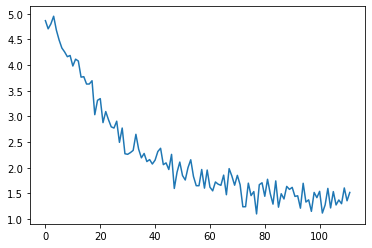

In [ ]:
plt.plot(loss_total)
plt.show()

이렇게 학습의 시간이 오래 걸릴 경우 모델의 가중치를 저장하면 나중에 이어서 학습 할 수 있다. 모델의 가중치는 `state_dict` 메소드로 불러올 수 있다.

가중치를 pickle 혹은 `torch.save` 메소드로 저장할 수 있다.

In [ ]:
# pytorch 에서는 pt 혹은 pth 확장자를 쓰는 것이 일반적인 규칙
# pickle 쓰는 것과 torch.save 쓰는 것은 완전히 같음
# with open("./data/dog_breed/weight.pt", "wb") as f:
#     pickle.dump(model.state_dict())

torch.save(model.state_dict(), "./data/dog_breed/weight.pt")

저장한 가중치를 다음과 같이 모델에 적용 할 수 있다.

In [ ]:
# with open("./data/dog_breed/weight.pt", "rb") as f:
#    model.load_state_dict(pickle.load(f))

model.load_state_dict(torch.load("./data/dog_breed/weight.pt"))

<All keys matched successfully>

In [ ]:
for epoch in range(epoch_num):
    loss_h = []
    acc_h = []
    for X_b, y_b in tqdm(loader):
        optim.zero_grad()
        out = model(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optim.step()
        
        loss_h.append(loss.item())
        loss_total.append(loss.item())
        acc_h.append(model.acc_score(out, y_b) * X_b.shape[0])
        
    print(f"{epoch + 1}/{epoch_num}")
    print(f"loss: {np.mean(loss_h)} accuracy: {np.sum(acc_h) / X_tr.shape[0]}")
    torch.save(model.state_dict(), "./data/dog_breed/weight.pt")

  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

1/10
loss: 1.002870146717344 accuracy: 0.7035639414414087


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

2/10
loss: 0.7327817997762135 accuracy: 0.7700908456958315


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

3/10
loss: 0.57306626864842 accuracy: 0.8111809924296947


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

4/10
loss: 0.4385785687980907 accuracy: 0.8546471000300847


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

5/10
loss: 0.3203674541520221 accuracy: 0.8989517820289633


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

6/10
loss: 0.2538144426154239 accuracy: 0.9176799441366909


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

7/10
loss: 0.19070370152725705 accuracy: 0.9446540880669755


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

8/10
loss: 0.15869630627068027 accuracy: 0.9513626834714771


  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

9/10
loss: 0.11563505152506488 accuracy: 0.9688329839606455


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [04:23<00:00,  2.36s/it]

10/10
loss: 0.09512767648058278 accuracy: 0.9763801537719663


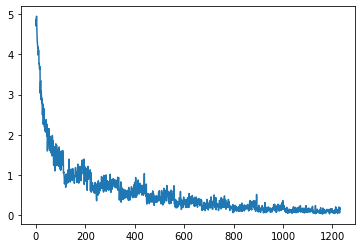

In [ ]:
plt.plot(loss_total)
plt.show()

In [ ]:
model.load_state_dict(torch.load("./data/dog_breed/weight.pt"))

<All keys matched successfully>

In [ ]:
sum(model.acc_score(model(X).argmax(1), y) * bs for X, y in tqdm(DataLoader(TensorDataset(X_tst, y_tst), bs, shuffle=True))) / X_tst.shape[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [01:56<00:00,  2.42s/it]


0.8978629807210101

Kaggle 제출용 데이터를 만든다. 저장했던 `resize_t`를 불러와서 진행한다.

In [ ]:
del X_tr, y_tr, X_tst, y_tst

In [ ]:
with open("data/dog_breed/resize_t.pickle", "rb") as f:
    resize_t = pickle.load(f)

resize_t = resize_t.transpose(0, 3, 1, 2)
id_t = list(map(lambda x:x.split('.')[0], tstlist))
X_t = torch.tensor(resize_t) / 255
del resize_t

X_t.shape

torch.Size([10357, 3, 224, 224])

DataLoader에서 shuffle을 하면 데이터 순서가 바뀐다. 원래 순서를 알아야 각 데이터의 id를 알 수 있기 때문에 이를 저장해야 한다.

확률을 제출해야 하기 때문에 model의 출력에 Softmax를 적용한다.

In [ ]:
testds_idx = TensorDataset(X_t, torch.arange(X_t.shape[0]))
p = list((F.softmax(model(X), dim=1), idx) for X, idx in tqdm(DataLoader(testds_idx, bs, shuffle=True)))

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [06:58<00:00,  2.59s/it]


In [ ]:
prob_t = torch.cat(list(map(lambda x: x[0], p)))

prob_t.shape

torch.Size([10357, 120])

In [ ]:
idx_t = torch.cat(list(map(lambda x: x[1], p)))

idx_t.dtype

torch.int64

`id_t`에 id 값이 순서대로 있다. `idx_t`배열에 shuffle 이전 인덱스가 저장되어 있으므로 각 데이터에 대한 id 값을 구할 수 있다.

In [ ]:
df = pd.DataFrame(prob_t.detach().numpy())
df["id"] = np.array(id_t)[idx_t]

df.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,id
0,2.440427e-08,3.994605e-14,4.747350e-14,9.967849e-01,1.521565e-13,1.261014e-10,9.787302e-14,2.399017e-10,5.791283e-09,5.185723e-12,...,3.115616e-10,5.700575e-12,1.023885e-04,2.379364e-13,2.897463e-09,5.574779e-09,3.190932e-09,1.411590e-10,1.471116e-05,3d175317de266fa14704357907d9f37b
1,6.368363e-11,5.465104e-10,2.276990e-11,2.189592e-12,6.453770e-09,4.739259e-15,1.160026e-11,1.812407e-10,2.852131e-11,3.261690e-09,...,1.047190e-02,2.086013e-09,8.049673e-15,1.955693e-12,4.843322e-09,6.046625e-12,6.828286e-14,1.217297e-07,4.930141e-13,76d1bf760bb0fc5d457442bf5de4fac6
2,4.982583e-16,4.595289e-11,7.406263e-16,1.020566e-13,1.491467e-07,8.071647e-11,9.313666e-08,2.977219e-19,2.045293e-12,2.897213e-18,...,1.300197e-15,9.176887e-18,4.003312e-16,3.162788e-16,8.275500e-16,2.793070e-11,1.333651e-17,1.075993e-10,4.108266e-16,3fec37cd9a14af7fca18520d5fa3a070
3,3.632267e-11,4.414163e-08,1.410409e-13,5.181600e-11,3.441672e-07,5.936348e-12,3.398507e-11,6.564108e-09,3.808393e-10,6.067091e-13,...,8.906034e-10,1.656216e-10,3.465418e-07,9.161270e-13,8.455311e-12,3.143534e-13,6.900681e-12,8.953208e-11,6.573041e-09,421740219b36fc0bd5d5f043f7c9df62
4,2.453279e-09,4.200903e-09,1.605103e-15,8.891653e-12,1.501226e-14,1.151440e-11,6.820229e-07,2.936930e-05,4.121894e-11,1.846319e-09,...,1.205351e-11,6.959996e-16,2.484992e-09,4.759389e-11,2.635809e-15,6.432151e-18,5.490403e-09,3.440327e-15,8.023629e-16,b138ee2179ec8871d9534e81a54517bd


In [ ]:
df = df.rename(columns={key: val for key, val in zip(df.columns[:-1], uniques)})

df.head()

,boston_bull,dingo,pekinese,bluetick,golden_retriever,bedlington_terrier,borzoi,basenji,scottish_deerhound,shetland_sheepdog,...,silky_terrier,sussex_spaniel,german_short-haired_pointer,french_bulldog,bouvier_des_flandres,tibetan_mastiff,english_springer,cocker_spaniel,rottweiler,id
0,2.440427e-08,3.994605e-14,4.747350e-14,9.967849e-01,1.521565e-13,1.261014e-10,9.787302e-14,2.399017e-10,5.791283e-09,5.185723e-12,...,3.115616e-10,5.700575e-12,1.023885e-04,2.379364e-13,2.897463e-09,5.574779e-09,3.190932e-09,1.411590e-10,1.471116e-05,3d175317de266fa14704357907d9f37b
1,6.368363e-11,5.465104e-10,2.276990e-11,2.189592e-12,6.453770e-09,4.739259e-15,1.160026e-11,1.812407e-10,2.852131e-11,3.261690e-09,...,1.047190e-02,2.086013e-09,8.049673e-15,1.955693e-12,4.843322e-09,6.046625e-12,6.828286e-14,1.217297e-07,4.930141e-13,76d1bf760bb0fc5d457442bf5de4fac6
2,4.982583e-16,4.595289e-11,7.406263e-16,1.020566e-13,1.491467e-07,8.071647e-11,9.313666e-08,2.977219e-19,2.045293e-12,2.897213e-18,...,1.300197e-15,9.176887e-18,4.003312e-16,3.162788e-16,8.275500e-16,2.793070e-11,1.333651e-17,1.075993e-10,4.108266e-16,3fec37cd9a14af7fca18520d5fa3a070
3,3.632267e-11,4.414163e-08,1.410409e-13,5.181600e-11,3.441672e-07,5.936348e-12,3.398507e-11,6.564108e-09,3.808393e-10,6.067091e-13,...,8.906034e-10,1.656216e-10,3.465418e-07,9.161270e-13,8.455311e-12,3.143534e-13,6.900681e-12,8.953208e-11,6.573041e-09,421740219b36fc0bd5d5f043f7c9df62
4,2.453279e-09,4.200903e-09,1.605103e-15,8.891653e-12,1.501226e-14,1.151440e-11,6.820229e-07,2.936930e-05,4.121894e-11,1.846319e-09,...,1.205351e-11,6.959996e-16,2.484992e-09,4.759389e-11,2.635809e-15,6.432151e-18,5.490403e-09,3.440327e-15,8.023629e-16,b138ee2179ec8871d9534e81a54517bd


In [ ]:
df.to_csv("./data/dog_breed/res.csv", index=False)